In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import re
import scipy.io as scio
import os
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
%config InlineBackend.figure_format = 'retina'
os.sys.path.append('lib/sharpy-analysis-tools/')
import linear.stability as stability

In [2]:
path_to_mrm = 'mrm_data/'
path_to_aepw3 = '/home/ng213/2TB/pazy_code/pazy-aepw3-results/'

In [21]:
file_names = {}
file_names['0'] = {'mrm': 'AE results from MRM of UM beam model wing 1 WO skin updated',
                  'results': 'mrm_umbeam_wo_skin'}
file_names['1'] = {'mrm': 'AE results from MRM of UM beam model wing 1 W skin ea at 44',
                  'results': 'mrm_umbeam_w_skin'}
file_names['2'] = {'mrm': 'AE results from MRM of Nastran model wing 1',
                  'results': 'mrm_nastran'}
file_names['3'] = {'mrm': 'AE results from MRM of Nastran model wing 1 with weight',
                  'results': 'mrm_nastran_te1'}
file_names['4'] = {'mrm': 'AE results from MRM of UM beam model wing 1 W skin improved QHH',
                  'results': 'mrm_umbeam_w_skin_qhh'}
file_names['5'] = {'mrm': 'AE results from MRM of UM beam model wing 1 WO skin improved QHH',
                  'results': 'mrm_umbeam_wo_skin_qhh'}
file_names['6'] = {'mrm': 'AE results from MRM of UM beam model wing 1 WO skin refined',
                  'results': 'mrm_umbeam_wo_skin_refined'}
file_names['7'] = {'mrm': 'AE results from MRM of UM beam model wing 1 W skin refined',
                  'results': 'mrm_umbeam_w_skin_refined'}
file_names['8'] = {'mrm': 'torsion_test_W_skin',
                   'results': 'torsion_mrm_umbeam_w_skin'}
file_names['9'] = {'mrm': 'torsion_test_WO_skin',
                   'results': 'torsion_mrm_umbeam_wo_skin'}
file_names['10'] = {'mrm': 'bending_test_WO_skin',
                   'results': 'bending_mrm_umbeam_wo_skin'}
file_names['11'] = {'mrm': 'bending_test_W_skin',
                   'results': 'bending_mrm_umbeam_w_skin'}
file_names['12'] = {'mrm': 'Structural_Test_Torsion__UM_based_MRM',
                   'results': 'torsion_mrm_umbeam_wo_skin'}
file_names['13'] = {'mrm': 'follower_force_W_skin_UM_beam',
                   'results': 'mrm_followerforce_skin1'}
file_names['14'] = {'mrm': 'aeroelastic_analysis_W_skin_UM_beam',
                   'results': 'mrm_umbeam_w_skin'}
file_names['15'] = {'mrm': 'aeroelastic_analysis_WO_skin_UM_beam',
                   'results': 'mrm_umbeam_wo_skin'}
file_names['16'] = {'mrm': 'follower_force_WO_skin_UM_beam',
                   'results': 'mrm_followerforce_skin0'}
file_names['17'] = {'mrm': 'matcjed stability plot data',
                   'results': 'mrm_umbeam_aeroelastic_skin_off',
                    'skin': 'off',
                   'datervd': 'June2021'}
file_names['18'] = {'mrm': 'mached results norberto both AoA',
                   'results': '',
                   'datervd': 'June2021'}
# file_names['19'] = {'mrm': 'mached vg plots no skin V3 hopefully  working this time',
#                     'results': 'mrm_umbeam_wo_skin',
#                    'skin': 'off',
#                    'datervd': '3June2021'}
# file_names['20'] = {'mrm': 'mached vg plots with skin V3 hopefully  working this time',
#                     'results': 'mrm_umbeam_w_skin',
#                    'skin': 'on',
#                    'datervd': '3June2021'}
file_names['19'] = {'mrm': 'mached vg plots no skin V4 hopefully final',
                    'results': 'mrm_umbeam_wo_skin',
                   'skin': 'off',
                   'datervd': '5June2021'}
file_names['20'] = {'mrm': 'mached vg plots with skin V4 hopefully final',
                    'results': 'mrm_umbeam_w_skin',
                   'skin': 'on',
                   'datervd': '5June2021'}
file_names['21'] = {'mrm': 'structural anslysis bending test no skin, Ansys modes',
                    'results': 'bending_ansys_wo_skin',
                   'skin': 'on',
                   'datervd': '2June2021'}
file_names['22'] = {'mrm': 'structural anslysis bending test with skin, Ansys modes',
                    'results': 'bending_ansys_w_skin',
                   'skin': 'on',
                   'datervd': '2June2021'}
file_names['23'] = {'mrm': 'structural anslysis torsion test no skin, Ansys modes',
                    'results': 'torsion_ansys_wo_skin',
                   'skin': 'off',
                   'datervd': '3June2021'}
file_names['24'] = {'mrm': 'structural anslysis torsion test with skin, Ansys modes',
                    'results': 'torsion_ansys_w_skin',
                   'skin': 'on',
                   'datervd': '3June2021'}
# file_names['25'] = {'mrm': 'undeformed vg plot no skin',
#                     'results': 'mrm_umbeam_wo_skin',
#                    'skin': 'off',
#                    'datervd': '3June2021'}
# file_names['26'] = {'mrm': 'undeformed vg plot with skin',
#                     'results': 'mrm_umbeam_w_skin',
#                    'skin': 'on',
#                    'datervd': '3June2021'}mached vg plots with skin V4 hopefully final
file_names['25'] = {'mrm': 'undeformed vg plots no skin V4 hopefully final',
                    'results': 'mrm_umbeam_wo_skin',
                   'skin': 'off',
                   'datervd': '5June2021'}
file_names['26'] = {'mrm': 'undeformed vg plots with skin V4 hopefully final',
                    'results': 'mrm_umbeam_w_skin',
                   'skin': 'on',
                   'datervd': '5June2021'}

## NEW STRUCTURAL DATA RECEIVED 5 JUNE 2021
# TORSION
file_names['8'] = {'mrm': 'torsion_with_cover_test_MRM_UMbased',
                   'results': 'torsion_mrm_umbeam_w_skin',
                    'skin': 'on',
                   'datervd': '5June2021'}
file_names['9'] = {'mrm': 'torsion_no_cover_test_MRM_UMbased',
                   'results': 'torsion_mrm_umbeam_wo_skin',
                   'skin': 'off',
                   'datervd': '5June2021'}
file_names['23'] = {'mrm': 'torsion_with_cover_test_MRM_FEbased',
                    'results': 'torsion_ansys_w_skin',
                   'skin': 'on',
                   'datervd': '5June2021'}
file_names['24'] = {'mrm': 'torsion_no_cover_test_MRM_FEbased',
                    'results': 'torsion_ansys_wo_skin',
                   'skin': 'off',
                   'datervd': '5June2021'}

# BENDING
file_names['10'] = {'mrm': 'bend_with_cover_test_MRM_UMbased',
                   'results': 'bending_mrm_umbeam_w_skin',
                    'skin': 'on',
                   'datervd': '5June2021'}
file_names['11'] = {'mrm': 'bend_no_cover_test_MRM_UMbased',
                   'results': 'bending_mrm_umbeam_wo_skin',
                   'skin': 'off',
                   'datervd': '5June2021'}
file_names['21'] = {'mrm': 'bend_with_cover_test_MRM_FEbased',
                    'results': 'bending_ansys_w_skin',
                   'skin': 'on',
                   'datervd': '5June2021'}
file_names['22'] = {'mrm': 'bend_no_cover_test_MRM_FEbased',
                    'results': 'bending_ansys_wo_skin',
                   'skin': 'off',
                   'datervd': '5June2021'}

In [22]:
torsion_cases = [8, 9, 23, 24]
bending_cases = [10, 11, 21, 22]
followerforce_cases = [13, 16]
aeroelastic_cases = [14, 15]

In [616]:
mat = scio.loadmat(path_to_mrm + file_names['11']['mrm'] + '.mat')

In [617]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Norberto_Struct_Analysis_Data', 'Norberto_Struct_Test_Data'])

In [602]:
for k, v in mat.items():
    print('\n\n---------------------')
    print('Key:', k)
    try:
        print('Shape: ', v.shape)
#         print(v)
    except AttributeError:
        pass



---------------------
Key: __header__


---------------------
Key: __version__


---------------------
Key: __globals__


---------------------
Key: Norberto_Static_AE_Data
Shape:  (21, 1)


---------------------
Key: Norberto_frequency_Data
Shape:  (21, 4)


---------------------
Key: Norberto_frequency_Data_Direct
Shape:  (21, 4)


---------------------
Key: Norberto_weight_data
Shape:  (1, 21)


---------------------
Key: norberto_deformed_shape
Shape:  (1, 750)


# Bending

In [23]:
def bending(mat, data_type):
    if data_type == 'mrm':
        load = mat['Norberto_Struct_Analysis_Data'][:, 0]
        deflection = mat['Norberto_Struct_Analysis_Data'][:, 1]
    else:
        load = mat['Norberto_Struct_Test_Data'][:, 0]
        deflection = mat['Norberto_Struct_Test_Data'][:, 1]
    # modes_freq = mat['Norberto_frequency_Data']
    return load, deflection

In [26]:
for file_num in bending_cases:
    mat = scio.loadmat(path_to_mrm + '/' + file_names[str(file_num)]['mrm'] + '.mat')
    print('Processing {:s}'.format(file_names[str(file_num)]['mrm']))
    
    load, deflection = bending(mat, 'mrm')
    output_path = path_to_aepw3 + '/01_Bending/'
    np.savetxt(output_path + file_names[str(file_num)]['results'] + '.txt', np.column_stack((load, deflection)))
    print('Saved to', output_path + file_names[str(file_num)]['results'] + '.txt')
    
    load, deflection = bending(mat, 'exp')
    output_path = path_to_aepw3 + '/01_Bending/'
    if '_w_skin' in file_names[str(file_num)]['results']:
        filename = 'bending_technion_experimental_w_skin'
    else:
        filename = 'bending_technion_experimental_wo_skin'

    np.savetxt(output_path + filename + '.txt', np.column_stack((load, deflection)))
    
#     modes_output = path_to_aepw3 + '/04_DeformedModal/'
#     if not os.path.isdir(modes_output + '/' + file_names[str(file_num)]['results']):
#         os.makedirs(modes_output + '/' + file_names[str(file_num)]['results'])
    
#     for i in range(modes_freq.shape[1]):
#         np.savetxt(modes_output + '/' + file_names[str(file_num)]['results'] + '/mode_{:02g}.txt'.format(i),
#                   np.column_stack((load, deflection, modes_freq[:, i] * 2 * np.pi)))

Processing bend_with_cover_test_MRM_UMbased
Saved to /home/ng213/2TB/pazy_code/pazy-aepw3-results//01_Bending/bending_mrm_umbeam_w_skin.txt
Processing bend_no_cover_test_MRM_UMbased
Saved to /home/ng213/2TB/pazy_code/pazy-aepw3-results//01_Bending/bending_mrm_umbeam_wo_skin.txt
Processing bend_with_cover_test_MRM_FEbased
Saved to /home/ng213/2TB/pazy_code/pazy-aepw3-results//01_Bending/bending_ansys_w_skin.txt
Processing bend_no_cover_test_MRM_FEbased
Saved to /home/ng213/2TB/pazy_code/pazy-aepw3-results//01_Bending/bending_ansys_wo_skin.txt


# Torsion

In [19]:
def torsion(mat, data_type):
    if data_type == 'mrm':
        load = mat['Norberto_Struct_Analysis_Data'][:, 0]
        deflection = mat['Norberto_Struct_Analysis_Data'][:, 1]
        angle = mat['Norberto_Struct_Analysis_Data'][:, 2]
    else:
        load = mat['Norberto_Struct_Test_Data'][:, 0]
        deflection = mat['Norberto_Struct_Test_Data'][:, 1]
        angle = mat['Norberto_Struct_Test_Data'][:, 2]


    # modes_freq = mat['Norberto_frequency_Data']
    return load, deflection, angle

In [27]:
for file_num in torsion_cases:
    mat = scio.loadmat(path_to_mrm + '/' + file_names[str(file_num)]['mrm'] + '.mat')
    print('Processing {:s}'.format(file_names[str(file_num)]['mrm']))
    
    load, deflection, angle = torsion(mat, 'mrm')
    output_path = path_to_aepw3 + '/02_Torsion/'
    np.savetxt(output_path + file_names[str(file_num)]['results'] + '.txt', np.column_stack((load, deflection, angle)))
    print('Saved to', output_path + file_names[str(file_num)]['results'] + '.txt')
    load, deflection, angle = torsion(mat, 'exp')
    if '_w_skin' in file_names[str(file_num)]['results']:
        filename = 'torsion_technion_experimental_w_skin'
    else:
        filename = 'torsion_technion_experimental_wo_skin'

    np.savetxt(output_path + filename + '.txt', np.column_stack((load, deflection, angle)))

Processing torsion_with_cover_test_MRM_UMbased
Saved to /home/ng213/2TB/pazy_code/pazy-aepw3-results//02_Torsion/torsion_mrm_umbeam_w_skin.txt
Processing torsion_no_cover_test_MRM_UMbased
Saved to /home/ng213/2TB/pazy_code/pazy-aepw3-results//02_Torsion/torsion_mrm_umbeam_wo_skin.txt
Processing torsion_with_cover_test_MRM_FEbased
Saved to /home/ng213/2TB/pazy_code/pazy-aepw3-results//02_Torsion/torsion_ansys_w_skin.txt
Processing torsion_no_cover_test_MRM_FEbased
Saved to /home/ng213/2TB/pazy_code/pazy-aepw3-results//02_Torsion/torsion_ansys_wo_skin.txt


# Follower Force

WIP - few things to check before

In [614]:
def follower_force(mat, direct=False):
    load = mat['Norberto_weight_data']
    mode_data = []
    n_modes = mat['Norberto_frequency_Data'].shape[1]
    
    for i_mode in range(n_modes):
        if direct:
            freq = mat['Norberto_frequency_Data_Direct'][:, i_mode]
        else:
            freq = mat['Norberto_frequency_Data'][:, i_mode]
        data = np.column_stack((load.T * 9.81, mat['Norberto_Static_AE_Data'], freq * 2 * np.pi))
        mode_data.append(data)
        
    return mode_data

In [615]:
for file_num in followerforce_cases:
    mat = scio.loadmat(path_to_mrm + '/' + file_names[str(file_num)]['mrm'] + '.mat')
    print('Processing {:s}'.format(file_names[str(file_num)]['mrm']))
    
    # Modal approach
    mode_data = follower_force(mat)
    output_path = path_to_aepw3 + '/04_DeformedModal/' + '/' + file_names[str(file_num)]['results']
    os.makedirs(output_path, exist_ok=True)
    for i_mode in range(len(mode_data)):
        np.savetxt(output_path + '/mode_{:02g}.txt'.format(i_mode), mode_data[i_mode])
    
    # Direct
    mode_data = follower_force(mat, direct=True)
    output_path = path_to_aepw3 + '/04_DeformedModal/' + '/' + file_names[str(file_num)]['results'] + '_direct'
    os.makedirs(output_path, exist_ok=True)
    for i_mode in range(len(mode_data)):
        np.savetxt(output_path + '/mode_{:02g}.txt'.format(i_mode), mode_data[i_mode])

Processing follower_force_W_skin_UM_beam
Processing follower_force_WO_skin_UM_beam


In [443]:
k_vec = np.array([0, 0.0200000000000000, 0.0300000000000000, 0.0400000000000000, 0.0500000000000000, 0.0600000000000000, 0.0700000000000000, 0.100000000000000,
                  0.120000000000000, 0.125000000000000, 0.130000000000000, 0.140000000000000, 0.150000000000000, 0.200000000000000, 0.250000000000000,
                  0.300000000000000, 0.400000000000000, 0.500000000000000, 0.600000000000000, 0.700000000000000, 0.800000000000000, 0.900000000000000, 1, 1.50000000000000])

print('Length k', len(k_vec))

Length k 24


In [422]:
def frequency(mat, i_aoa):
    vels = []
    freqs = []
    for i in range(4):
#         plt.scatter(mat['Norberto_Vel_Data'][:, 0], mat['Norberto_frequency_Data'][:, i, 0])
        vels.append(mat['Norberto_Vel_Data'][:, 0].astype(float))
        freqs.append(mat['Norberto_frequency_Data'][:, i, i_aoa])
    vels = np.concatenate(vels)
    freqs = np.concatenate(freqs)
    order = np.argsort(vels)
    vels = np.array([vels[i] for i in order])
    freqs = np.array([freqs[i] for i in order])
#     print(vels)
#     print(freqs)
#     plt.scatter(vels, freqs)
    return vels, freqs

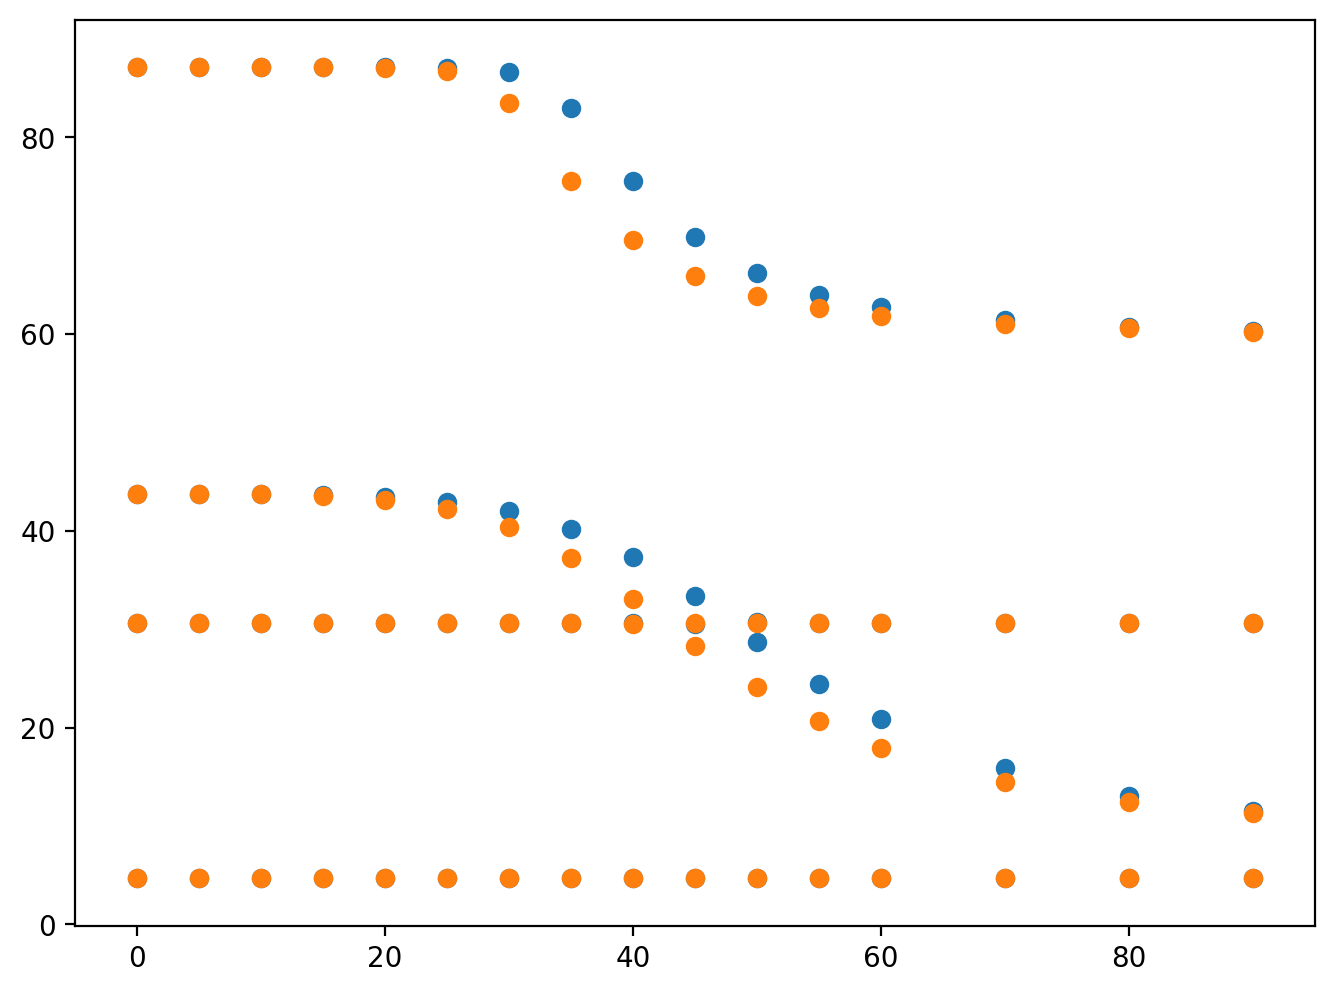

In [423]:
plt.scatter(*frequency(mat, 0))
plt.scatter(*frequency(mat, 1))

In [581]:
def static_deflection_speed(mat, i_aoa):
    vels = mat['Norberto_Vel_Data'][:, 0].astype(float)
    deflection = mat['Norberto_Static_AE_Data'][:, i_aoa]

    return vels, deflection

In [582]:
def matched_flutter(mat, i_aoa):
    if i_aoa is not None:
        deflection = mat['Norberto_Static_AE_Data'][:, i_aoa]
        vels = mat['Norberto_Vel_Data'][:, 0].astype(float)
        flutter_speed = mat['Norberto_vf_mached_Data'][0, i_aoa+1]
        deflection_at_vf = np.interp(flutter_speed, vels, deflection)
    
        return flutter_speed, deflection_at_vf
    else:
        return mat['Norberto_vf_mached_Data'][0, 0], 0

In [583]:
def nonmatched_flutter(mat, i_aoa):
    deflection = mat['Norberto_Static_AE_Data'][:, i_aoa]
    vels = mat['Norberto_Vel_Data'][:, 0].astype(float)
    flutter_speed = mat['Norberto_nonmached_flutter_Data'][:, 0, i_aoa]
#     deflection_at_vf = np.interp(flutter_speed, vels, deflection)
    return deflection, flutter_speed

In [584]:
def aero_freqresp(mat, aoa, i_aoa, path):
    mlist = [1, 2, 3]
    plist = [1, 2, 3]
    vels = mat['Norberto_Vel_Data'][:, 0].astype(float)
    
    for i_vel, vel in enumerate(vels):
        # print(vel)
        file_path = path + '_uinf{:04g}_alpha{:04g}'.format(vel * 10, aoa* 100)
        os.makedirs(file_path, exist_ok=True)
        for i_p, p in enumerate(plist):
            for i_m, m in enumerate(mlist):
                try:
                    raw_freq = mat['Norberto_Qhh{:g}{:g}_data'.format(p, m)]
                except KeyError:
#                     raw_freq = mat['Norberto_Qhh{:g}{:g}_data_eigen_coords'.format(p, m)]
                    raw_freq = mat['Norberto_Qhh{:g}{:g}_data_constnt_modes'.format(p, m)]



                np.savetxt(file_path + '/in{:02g}_out{:02g}.txt'.format(i_p, i_m), np.column_stack((k_vec, raw_freq[:, i_vel, i_aoa].real, raw_freq[:, i_vel, i_aoa].imag)))


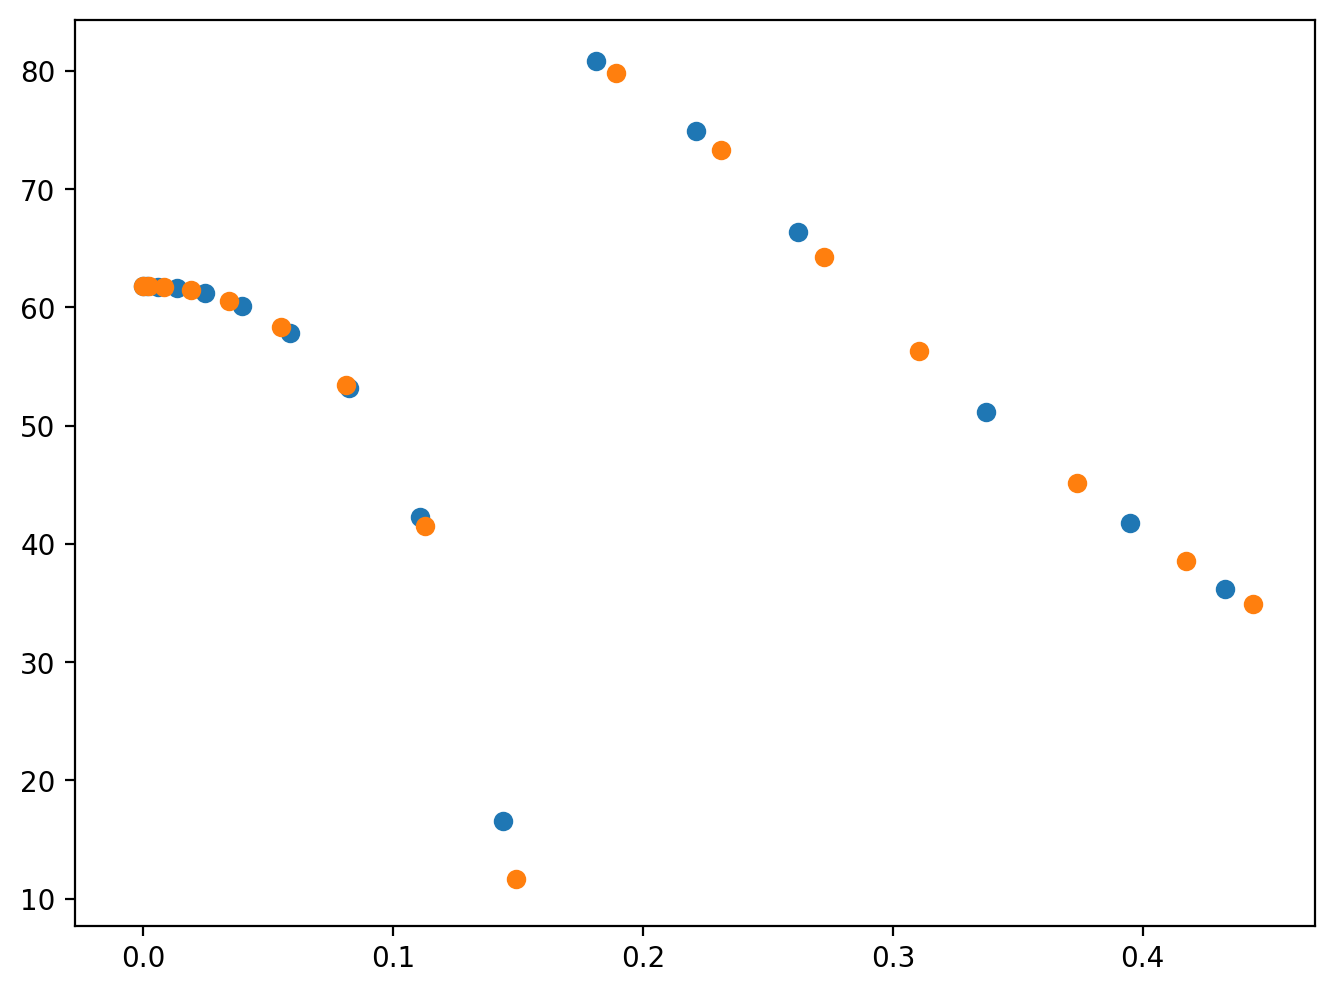

In [585]:
plt.scatter(*nonmatched_flutter(mat, 0))
plt.scatter(*nonmatched_flutter(mat, 1))

# Save in AEPW3 - Aeroelastic Cases

In [586]:

for i in aeroelastic_cases: #len(file_names)):
    
    if not os.path.isdir(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results']):
        os.makedirs(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results'])
    
    mat = scio.loadmat(path_to_mrm + '/' + file_names[str(i)]['mrm'] + '.mat')
    print('Processing {:s}'.format(file_names[str(i)]['mrm']))
    aoa = [5., 7.]
    for i_aoa in range(len(aoa)):
        # VELOCITY FREQUENCY
        vels, freq = frequency(mat, i_aoa)
        np.savetxt(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results'] + '/velocity_frequency_alpha{:04g}.txt'.format(aoa[i_aoa] * 100),
                  np.column_stack((vels, freq)))
        
        # STATIC DEFLECTION SPEED
        vels, deflection = static_deflection_speed(mat, i_aoa)
        np.savetxt(path_to_aepw3 + '/03_StaticAeroelastic/' + file_names[str(i)]['results'] + '_alpha{:04g}.txt'.format(aoa[i_aoa] * 100),
                  np.column_stack((vels, deflection)))
        
        # DEFORMED FLUTTER
        vf, deflection = matched_flutter(mat, i_aoa)
        np.savetxt(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results'] + '/flutter_speeds_alpha{:04g}.txt'.format(aoa[i_aoa] * 100),
                  np.column_stack((vf, deflection)))
        
        # NONMATCHED FLUTTER
        deflection, vf = nonmatched_flutter(mat, i_aoa)
        np.savetxt(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results'] + '/nonmatched_flutter_speeds_alpha{:04g}.txt'.format(aoa[i_aoa] * 100),
                  np.column_stack((deflection / 0.55, vf)))
        
#         # AERO FREQRESP
#         path = './06_LinUVLM/output/postprocess/{:s}'.format(file_names[str(i)]['results'])
#         try:
#             aero_freqresp(mat, aoa[i_aoa], i_aoa, path)
#         except KeyError:
#             pass
    # STRAIGHT WING FLUTTER
    vf, deflection = matched_flutter(mat, None)
    np.savetxt(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results'] + '/flutter_speeds_alpha{:04g}.txt'.format(0.),
              np.column_stack((vf, deflection)))

Processing aeroelastic_analysis_W_skin_UM_beam
Processing aeroelastic_analysis_WO_skin_UM_beam


In [471]:
import os
for i in [15, 16]:
    
    if not os.path.isdir(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results']):
        os.makedirs(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results'])
    
    mat = scio.loadmat(path_to_mrm + '/' + file_names[str(i)]['mrm'] + '.mat')
    aoa = [5., 7.]
    for i_aoa in range(2):
        # AERO FREQRESP
        path = './06_LinUVLM/output/postprocess/{:s}'.format(file_names[str(i)]['results'])
        try:
            aero_freqresp(mat, aoa[i_aoa], i_aoa, path)
        except KeyError:
            pass

0.0
1.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
0.0
1.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
0.0
1.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
0.0
1.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0


# Deformed VGF

In [202]:
file_id = 20
mat = scio.loadmat(path_to_mrm + '/' + file_names[str(file_id)]['mrm'] + '.mat')

for k,v in mat.items():
    print(k)
    try:
        print(v.shape)
    except AttributeError:
        print(k, 'No Shape')

__header__
__header__ No Shape
__version__
__version__ No Shape
__globals__
__globals__ No Shape
AOA_vgplot_norbert
(1, 2)
f_mached_direct_norberto
(3, 37, 2)
f_mached_fullymodal_norberto
(3, 37, 2)
g_mached_direct_norberto
(3, 37, 2)
g_mached_fullymodal_norberto
(3, 37, 2)
velocities_vgplot_norberto
(1, 37)


In [203]:
mat['AOA_vgplot_norbert'] * 180 / np.pi

array([[1., 5.]])

In [204]:
for k,v in mat.items():
    print(k)
    try:
        print(v.shape)
    except AttributeError:
        print(k, 'No Shape')
data = []
for i_mode in range(3):
    data.append(np.column_stack((mat['velocities_vgplot_norberto'].T, mat['g_mached_direct_norberto'][i_mode, :].T, mat['f_mached_direct_norberto'][i_mode, :].T * 2 * np.pi)))

__header__
__header__ No Shape
__version__
__version__ No Shape
__globals__
__globals__ No Shape
AOA_vgplot_norbert
(1, 2)
f_mached_direct_norberto
(3, 37, 2)
f_mached_fullymodal_norberto
(3, 37, 2)
g_mached_direct_norberto
(3, 37, 2)
g_mached_fullymodal_norberto
(3, 37, 2)
velocities_vgplot_norberto
(1, 37)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 37 and the array at index 1 has size 2

In [6]:
def vgf2eigs(g, f):
    wn = f * 2 * np.pi
    zeta = g # Arik already divided g by 2
    real = zeta * wn 
#     imag = np.sqrt(wn ** 2 - real ** 2)
    imag = np.sqrt(1 - zeta ** 2) * wn
    return real + 1j * imag

No handles with labels found to put in legend.
No handles with labels found to put in legend.


mrm_umbeam_wo_skin
Loaded mrm_data//mached vg plots no skin V4 hopefully final.mat
Saved to  /home/ng213/2TB/pazy_code/pazy-aepw3-results//06_DeformedWingFlutter/mrm_umbeam_wo_skin/velocity_damping_frequency_alpha0100.txt
Saved to  /home/ng213/2TB/pazy_code/pazy-aepw3-results//06_DeformedWingFlutter/mrm_umbeam_wo_skin/velocity_damping_frequency_alpha0500.txt
mrm_umbeam_w_skin
Loaded mrm_data//mached vg plots with skin V4 hopefully final.mat
Saved to  /home/ng213/2TB/pazy_code/pazy-aepw3-results//06_DeformedWingFlutter/mrm_umbeam_w_skin/velocity_damping_frequency_alpha0100.txt
Saved to  /home/ng213/2TB/pazy_code/pazy-aepw3-results//06_DeformedWingFlutter/mrm_umbeam_w_skin/velocity_damping_frequency_alpha0500.txt


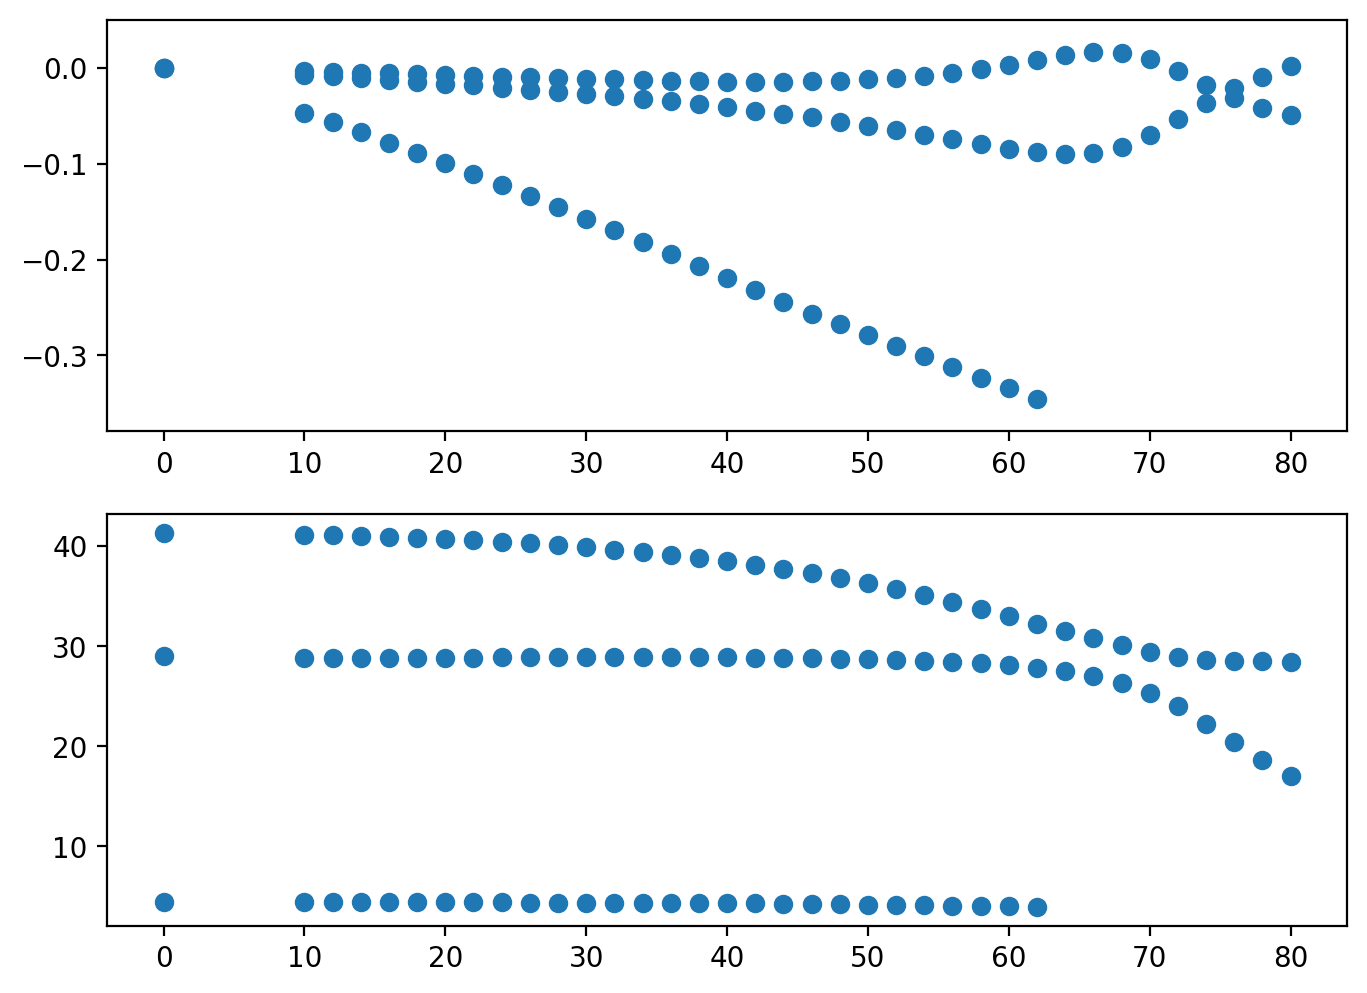

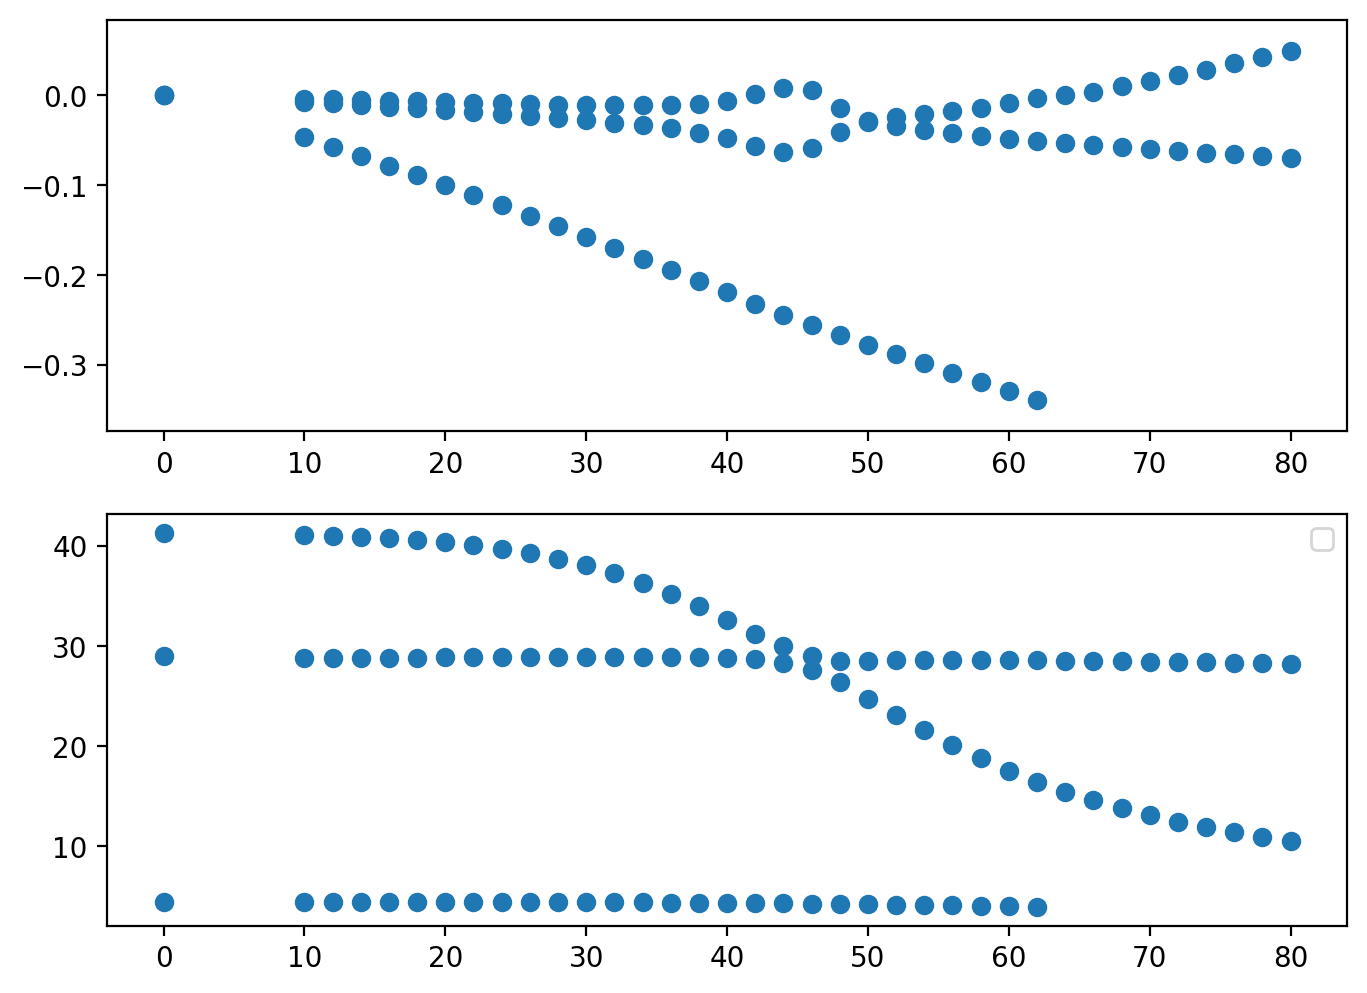

In [206]:
for file_id in [19, 20]:
    case_name = file_names[str(file_id)]['results']
    print(case_name)
    mat = scio.loadmat(path_to_mrm + '/' + file_names[str(file_id)]['mrm'] + '.mat')
    print('Loaded', path_to_mrm + '/' + file_names[str(file_id)]['mrm'] + '.mat')
    if not os.path.isdir(path_to_aepw3 + '/06_DeformedWingFlutter/' + case_name):
         os.makedirs(path_to_aepw3 + '/06_DeformedWingFlutter/' + case_name)

    for i_aoa in range(2):
        try:
            del res
        except NameError:
            pass
        try:
            del eigs
        except NameError:
            pass
        alpha = mat['AOA_vgplot_norbert'][0, i_aoa] * 180 / np.pi
        for i_vel in range(mat['velocities_vgplot_norberto'].shape[1]):
            vel = mat['velocities_vgplot_norberto'][0, i_vel]
            for i_mode in range(3):
                damp = mat['g_mached_fullymodal_norberto'][i_mode, i_vel, i_aoa]
                freq = mat['f_mached_fullymodal_norberto'][i_mode, i_vel, i_aoa]
                new_res = np.column_stack((vel, damp, freq))
                
                curr_eigs = vgf2eigs(damp, freq)
                new_eigs = np.column_stack((vel, curr_eigs.real, curr_eigs.imag))
                try:
                    res = np.vstack((res, new_res))
                    eigs = np.vstack((eigs, new_eigs))
                except NameError:
                    res = new_res
                    eigs = new_eigs
        if file_id == 19:
#             v, g, f = stability.modes(vel, eigs, use_hz=True)
            wn = np.sqrt(eigs[:, 1] ** 2 + eigs[:, 2] ** 2)
            damp = eigs[:, 1] / wn
            fig, ax = plt.subplots(nrows=2)
            ax[0].scatter(eigs[:, 0], damp)
            ax[1].scatter(eigs[:, 0], wn / 2/ np.pi)
    
        np.savetxt(path_to_aepw3 + '/06_DeformedWingFlutter/' + case_name + '/velocity_damping_frequency_alpha{:04g}.txt'.format(alpha * 100), res)
        np.savetxt(path_to_aepw3 + '/06_DeformedWingFlutter/' + case_name + '/velocity_eigenvalues_alpha{:04g}.txt'.format(alpha * 100), eigs)
        
        print('Saved to ', path_to_aepw3 + '/06_DeformedWingFlutter/' + case_name + '/velocity_damping_frequency_alpha{:04g}.txt'.format(alpha * 100))
        

            #     if file_id == 19:
#         plt.scatter(res[:, 0], res[:, 2], marker='+', label=file_names[str(file_id)]['mrm'] + '.mat')
#     elif file_id == 20:
#         plt.scatter(res[:, 0], res[:, 2], marker='x', label=file_names[str(file_id)]['mrm'] + '.mat')
    plt.legend(loc='upper right')

In [139]:
mat['AoA_vgplot_norbert']

KeyError: 'AoA_vgplot_norbert'

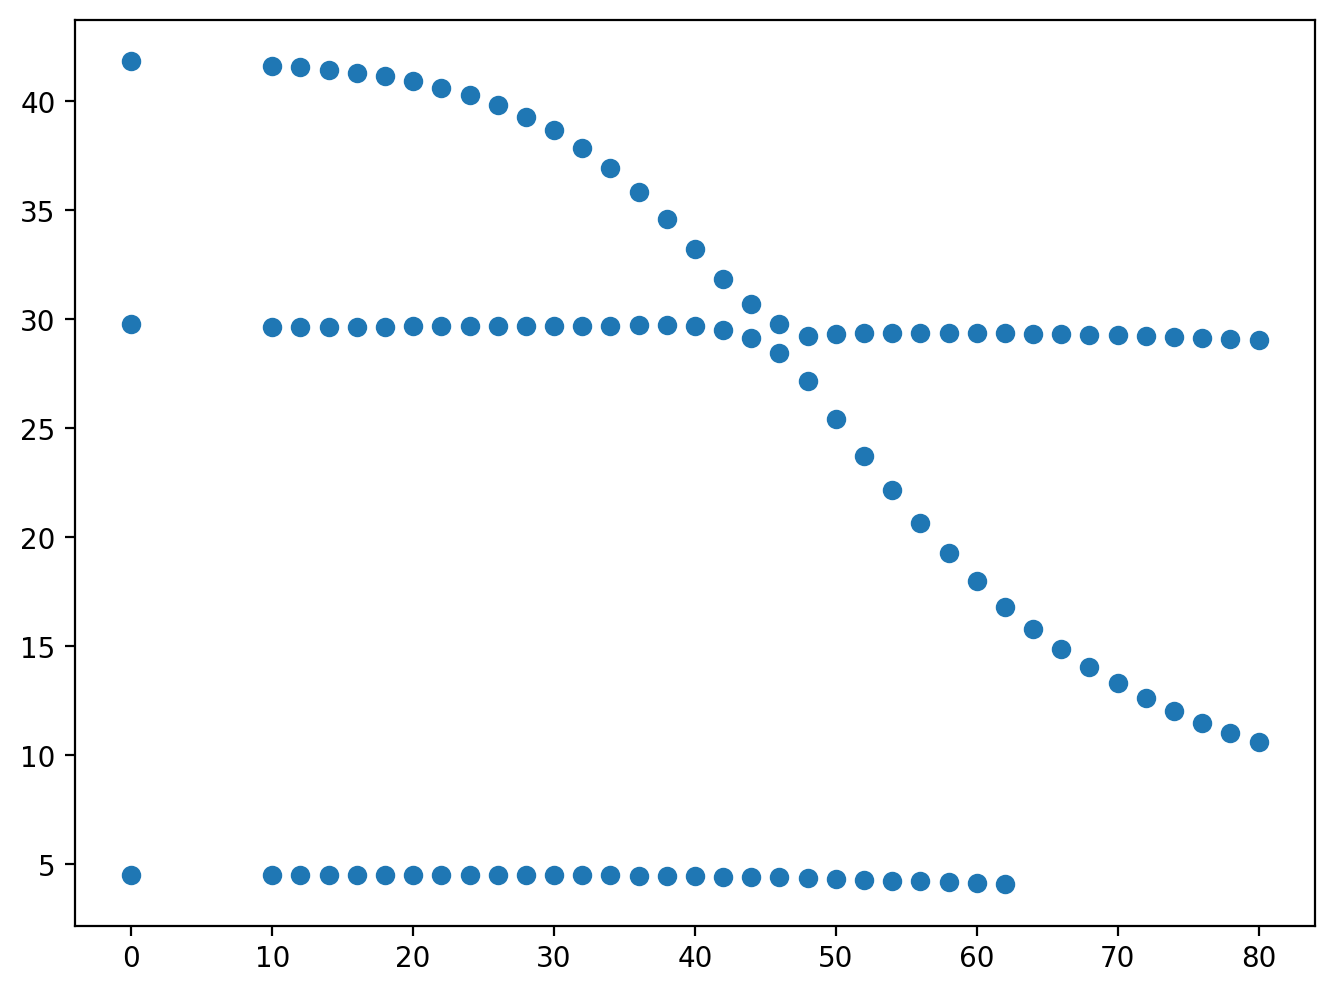

In [138]:
plt.scatter(res[:, 0], res[:, 2])

In [136]:
for res in data:
    plt.scatter(res[:, 0], res[:, 2])

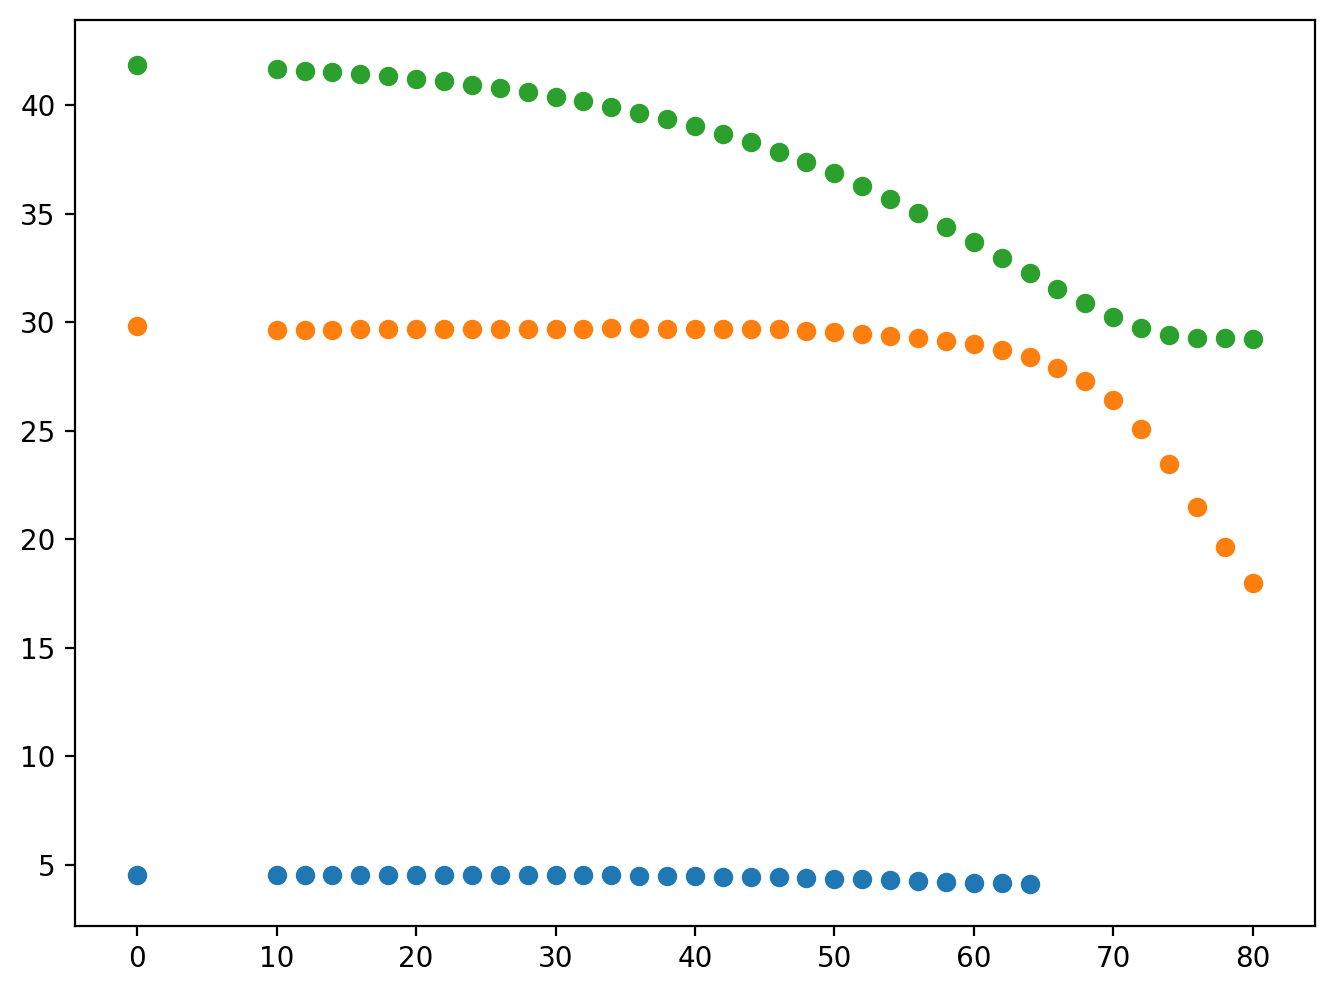

In [62]:
for i in range(3):
    plt.scatter(mat['velocities_vgplot_norberto'][0], mat['f_mached_fullymodal_norberto'][i, :, 0])

# Undeformed V-G-F plot

In [209]:
file_id = 26
mat = scio.loadmat(path_to_mrm + '/' + file_names[str(file_id)]['mrm'] + '.mat')

for k,v in mat.items():
    print(k)
    try:
        print(v.shape)
    except AttributeError:
        print(k, 'No Shape')

__header__
__header__ No Shape
__version__
__version__ No Shape
__globals__
__globals__ No Shape
AOA_vgplot_norbert
(1, 1)
f_mached_direct_norberto
(3, 47)
f_mached_fullymodal_norberto
(3, 47)
g_mached_direct_norberto
(3, 47)
g_mached_fullymodal_norberto
(3, 47)
velocities_vgplot_norberto
(1, 47)


mrm_umbeam_wo_skin
Loaded mrm_data//undeformed vg plots no skin V4 hopefully final.mat
Saved to  /home/ng213/2TB/pazy_code/pazy-aepw3-results//05_StraightWingFlutter/mrm_umbeam_wo_skin/velocity_damping_frequency_alpha0000.txt
mrm_umbeam_w_skin
Loaded mrm_data//undeformed vg plots with skin V4 hopefully final.mat
Saved to  /home/ng213/2TB/pazy_code/pazy-aepw3-results//05_StraightWingFlutter/mrm_umbeam_w_skin/velocity_damping_frequency_alpha0000.txt


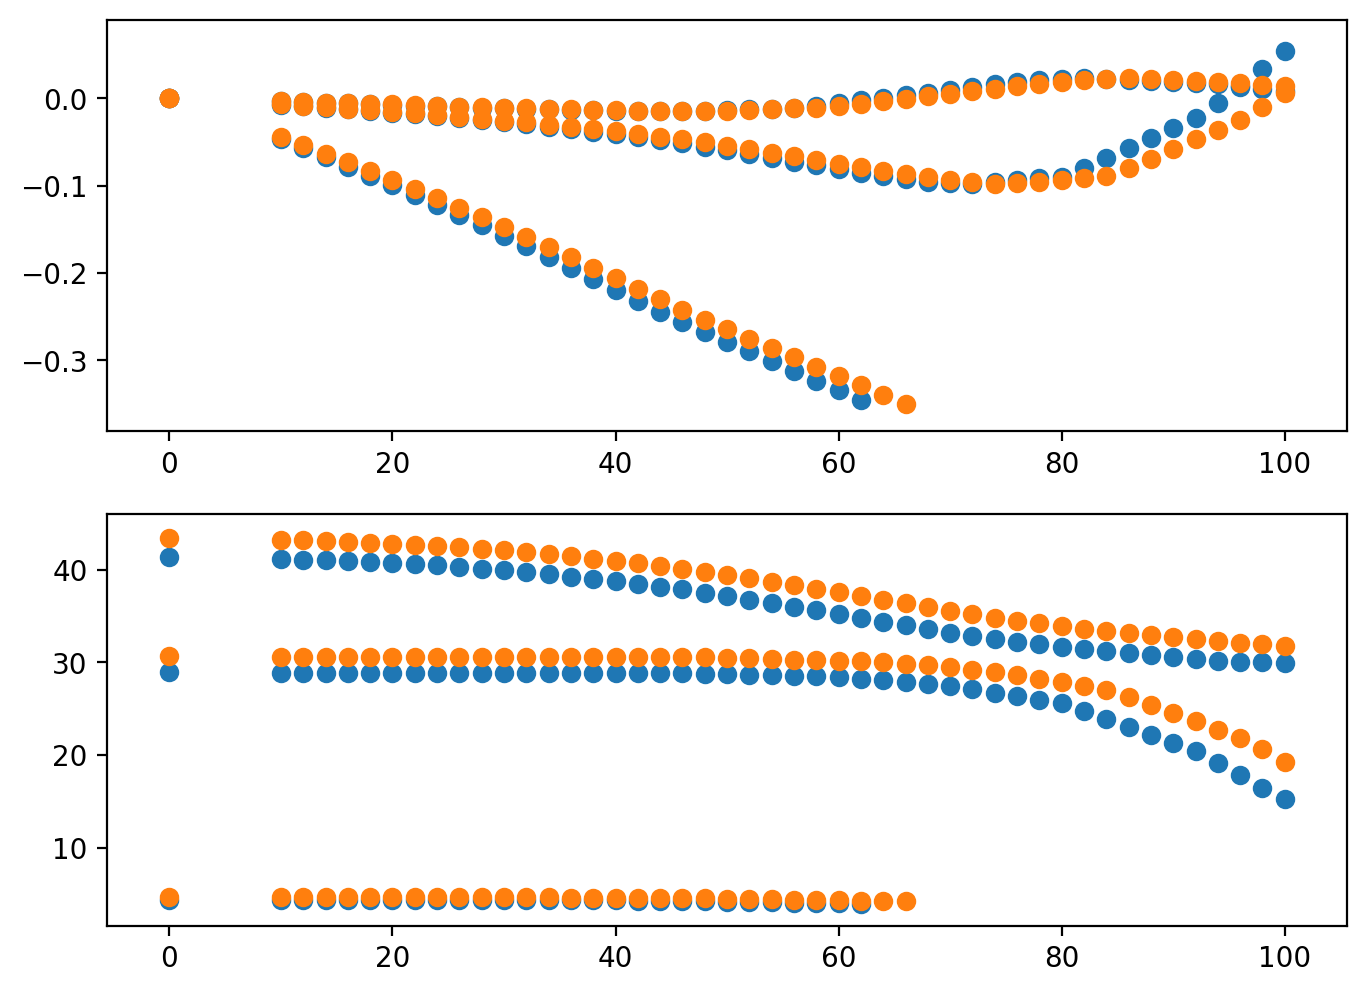

In [10]:
fig, ax = plt.subplots(nrows=2)
for file_id in [25, 26]:
    case_name = file_names[str(file_id)]['results']
    print(case_name)
    mat = scio.loadmat(path_to_mrm + '/' + file_names[str(file_id)]['mrm'] + '.mat')
    print('Loaded', path_to_mrm + '/' + file_names[str(file_id)]['mrm'] + '.mat')
    if not os.path.isdir(path_to_aepw3 + '/05_StraightWingFlutter/' + case_name):
         os.makedirs(path_to_aepw3 + '/05_StraightWingFlutter/' + case_name)

    try:
        del res
    except NameError:
        pass
    try:
        del eigs
    except NameError:
        pass
    alpha = 0
    for i_vel in range(mat['velocities_vgplot_norberto'].shape[1]):
        vel = mat['velocities_vgplot_norberto'][0, i_vel]
        for i_mode in range(3):
            damp = mat['g_mached_fullymodal_norberto'][i_mode, i_vel]
            freq = mat['f_mached_fullymodal_norberto'][i_mode, i_vel]
            new_res = np.column_stack((vel, damp, freq))

            curr_eigs = vgf2eigs(damp, freq)
            new_eigs = np.column_stack((vel, curr_eigs.real, curr_eigs.imag))
            try:
                res = np.vstack((res, new_res))
                eigs = np.vstack((eigs, new_eigs))
            except NameError:
                res = new_res
                eigs = new_eigs
#         if file_id == 19:
# #             v, g, f = stability.modes(vel, eigs, use_hz=True)
#             wn = np.sqrt(eigs[:, 1] ** 2 + eigs[:, 2] ** 2)
#             damp = eigs[:, 1] / wn
    ax[0].scatter(res[:, 0], res[:, 1])
    ax[1].scatter(res[:, 0], res[:, 2])
#     ax[2].scatter(eigs[:, 1], eigs[:, 2], c=eigs[:, 0])
    
    np.savetxt(path_to_aepw3 + '/05_StraightWingFlutter/' + case_name + '/velocity_damping_frequency_alpha{:04g}.txt'.format(alpha * 100), res)
    np.savetxt(path_to_aepw3 + '/05_StraightWingFlutter/' + case_name + '/velocity_eigenvalues_alpha{:04g}.txt'.format(alpha * 100), eigs)

    print('Saved to ', path_to_aepw3 + '/05_StraightWingFlutter/' + case_name + '/velocity_damping_frequency_alpha{:04g}.txt'.format(alpha * 100))
        


# fig, ax = plt.subplots(nrows=2)
# for i in range(6):
#     ax[0].scatter(mat['v'][i, :] / mat['w_ae'][i, :] / 0.005, mat['g'][i, :] * 2)
#     ax[1].scatter(mat['v'][i, :] / mat['w_ae'][i, :] / 0.005, mat['w_ae'][i, :] / 2/ np.pi)
    
# ax[0].set_xlim(0, 100)
# ax[0].grid()
# ax[1].set_xlim(0, 100)
# ax[1].set_ylim(0, 50)
# ax[0].set_ylim(-0.2, 0.2)

# FE Data

In [16]:
file_id = 24
mat = scio.loadmat(path_to_mrm + '/' + file_names[str(file_id)]['mrm'] + '.mat')

for k,v in mat.items():
    print(k)
    try:
        print(v.shape)
    except AttributeError:
        print(k, 'No Shape')

__header__
__header__ No Shape
__version__
__version__ No Shape
__globals__
__globals__ No Shape
Norberto_Struct_Analysis_Data
(10, 3)
Norberto_Struct_Test_Data
(17, 3)
